In [ ]:
import os, time, statistics, random
from pathlib import Path

import numpy as np
import pyarrow.parquet as pq
import torch
from torch.utils.data import DataLoader

from polyquant.data.datasets.sequence_dataset import MarketWindowDataset  # the file we wrote


In [ ]:
INDEX_PATH = r"C:\Users\nimro\PolyQuant\data\sequences\index.parquet"
SPLIT = "train"
L = 512
CAP = 8192

idx = pq.read_table(INDEX_PATH)
print("index rows:", idx.num_rows)
print("index cols:", idx.column_names)

# confirm split distribution
idx_pd = idx.select(["split"]).to_pandas()
print(idx_pd["split"].value_counts())

# show one row
print(idx.slice(0, 1).to_pylist()[0])


In [ ]:
# pick a shard path from the index
one = pq.read_table(INDEX_PATH, columns=["split","path"]).to_pandas()
one = one[one["split"] == SPLIT].iloc[0]
shard_path = one["path"]

pf = pq.ParquetFile(shard_path)
nrg = pf.metadata.num_row_groups
sizes = [pf.metadata.row_group(i).num_rows for i in range(nrg)]
print("shard:", shard_path)
print("row_groups:", nrg)
print("row_group rows min/med/max:", min(sizes), sorted(sizes)[len(sizes)//2], max(sizes))


In [4]:
ds = MarketWindowDataset(
    index_path=INDEX_PATH,
    split=SPLIT,
    L=L,
    cap_trades=CAP,
    min_prefix=20,
    pf_cache=64,
    include_ts=False,
)

print("markets in split:", len(ds))

x, u, mask, y = ds[0]
print("x:", x.shape, x.dtype)
print("u:", u.shape, u.dtype)
print("mask:", mask.shape, mask.dtype, "mask sum:", mask.sum().item())
print("y:", y.item(), y.dtype)

# padding assertions
pad = ~mask
assert torch.isfinite(x).all()
assert (x[pad] == 0).all(), "nonzero values in padded x"
assert (u[pad] == 0).all(), "nonzero user_hash in padded u"


markets in split: 113131
x: torch.Size([512, 10]) torch.float32
u: torch.Size([512]) torch.int64
mask: torch.Size([512]) torch.bool mask sum: 351
y: 1 torch.int64


In [5]:
def time_getitem(ds, n=200, seed=0):
    random.seed(seed)
    idxs = [random.randrange(len(ds)) for _ in range(n)]

    times = []
    for i in idxs:
        t0 = time.perf_counter()
        _ = ds[i]
        t1 = time.perf_counter()
        times.append((t1 - t0) * 1000.0)  # ms

    print(f"getitem latency over n={n}:")
    print("  mean ms:", statistics.mean(times))
    print("  p50  ms:", np.percentile(times, 50))
    print("  p90  ms:", np.percentile(times, 90))
    print("  p99  ms:", np.percentile(times, 99))
    print("  max  ms:", max(times))
    return times

times_ms = time_getitem(ds, n=200)


getitem latency over n=200:
  mean ms: 9.035762504208833
  p50  ms: 7.839500030968338
  p90  ms: 10.932450013933703
  p99  ms: 56.21177799766882
  max  ms: 58.69249999523163


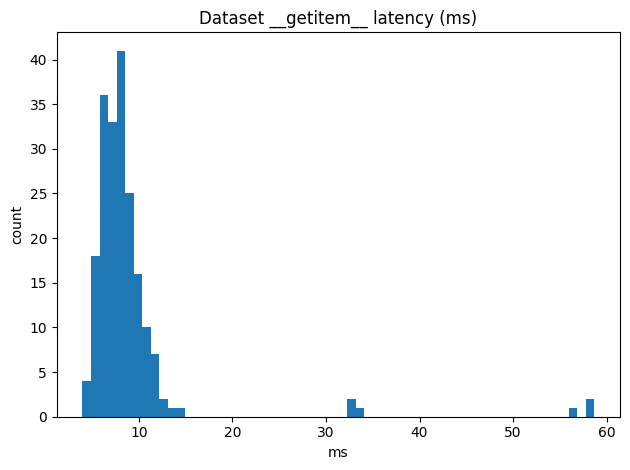

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(times_ms, bins=60)
plt.title("Dataset __getitem__ latency (ms)")
plt.xlabel("ms")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [7]:
def bench_dataloader(
    ds,
    batch_size=32,
    num_workers=0,
    n_batches=200,
    warmup=20,
    seed=0,
):
    g = torch.Generator()
    g.manual_seed(seed)

    dl = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        persistent_workers=(num_workers > 0),
        drop_last=True,
        pin_memory=False,
        generator=g,
    )

    it = iter(dl)
    for _ in range(warmup):
        next(it)

    t0 = time.perf_counter()
    n_samples = 0
    for _ in range(n_batches):
        x, u, mask, y = next(it)
        n_samples += x.shape[0]
    t1 = time.perf_counter()

    dt = t1 - t0
    sps = n_samples / dt
    ms_per_sample = 1000.0 * dt / n_samples
    print(f"bs={batch_size:3d} workers={num_workers}  batches={n_batches}  seconds={dt:.2f}")
    print(f"  samples/sec={sps:.1f}   ms/sample={ms_per_sample:.2f}")

# Try a few configs (Windows often likes 2–4 workers)
for nw in [0, 2, 4]:
    bench_dataloader(ds, batch_size=32, num_workers=nw, n_batches=200, warmup=20)


bs= 32 workers=0  batches=200  seconds=47.10
  samples/sec=135.9   ms/sample=7.36
bs= 32 workers=2  batches=200  seconds=33.06
  samples/sec=193.6   ms/sample=5.17
bs= 32 workers=4  batches=200  seconds=30.86
  samples/sec=207.4   ms/sample=4.82


In [8]:
for bs in [16, 32, 64]:
    bench_dataloader(ds, batch_size=bs, num_workers=2, n_batches=200, warmup=20)


bs= 16 workers=2  batches=200  seconds=17.76
  samples/sec=180.2   ms/sample=5.55
bs= 32 workers=2  batches=200  seconds=33.82
  samples/sec=189.2   ms/sample=5.29
bs= 64 workers=2  batches=200  seconds=72.41
  samples/sec=176.8   ms/sample=5.66
